In [1]:
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical
from sklearn.metrics import roc_auc_score
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

tf.compat.v1.disable_eager_execution()

from energyflow.archs.dnn import DNN
from energyflow.datasets import qg_nsubs
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

2023-08-31 18:44:46.598659: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 18:44:46.638683: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 18:44:46.811502: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 18:44:46.813633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 18:44:47.482444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Num GPUs Available:  0
GPUs Available:  []


/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:30: UserWarning: could not import some architectures - cannot import name 'cnn' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))
/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:40: UserWarning: could not import some architectures - cannot import name 'linear' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))


In [2]:



# Parameters 
train = 650000
val = 50000
test = 50000
k_order = 1

epochs = 50
batch_size=512
callbacks =None
verbose = 2

# directory = f"/n/home01/rikab/moment/models/O{k_order}/"
###########

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [k_order,] #
input_dim = 2
output_dim = 1


max_L = 2**(8-k_order)
F_width = 100
Phi_width = 100


Ls = []
j = max_L
while j >= 1:
    Ls.append(j)
    j = j / 2

num_samples = len(Ls)


# max_L_per_order = [2**(8-k_order),]
# F_min, F_max = 100
# Phi_min, Phi_max = 100
# logN_max = 6.5

def log_features(x):


    a = -3.5
    b = -1.0
    c = 0.005

    zs = x[:,0]

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    # ls = rs

    l_list = []

    for n in range(8 + 1):

        l_list.append(np.sum(zs * np.power(ls, n)))
    


    return np.array(l_list)



def cumulants(x):

    x[4,:] = np.nan_to_num(np.power(x[4,:] - 4*x[3,:]*x[1,:] - 3*x[2,:]**2 + 12*x[2,:]*x[1,:]**2 - 6*x[1,:]**4, 1))
    x[3,:] = np.nan_to_num(np.power(x[3,:] - 3*x[2,:]*x[1,:] + 2*x[1,:]**3, 1))
    x[2,:] = np.nan_to_num(np.power(x[2,:] - x[1,:]**2, 1))

    return x

# Data 
X, Y = qg_jets.load(train+val+test)

print("Data loaded!")


X = X[:,:,:3].astype(np.float32)
Y2 = to_categorical(Y, num_classes=2)
features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append((log_features(x)))

features = cumulants(np.array(features))





Data loaded!


In [3]:
rocs = []
for k_order in [1, 2, 3, 4]:


    (X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,:k_order+1], Y2, val=val, test=test)

    dense_sizes = (1,)

    dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='linear')

    # train model
    dnn.fit(X_train, Y_train,
            epochs=50,
            batch_size=500,
            validation_data=(X_val, Y_val),
            verbose=1)

    # get predictions on test data
    preds = dnn.predict(X_test, batch_size=1000)
    dnn.save_weights(f"Data/dnn/linear_O{k_order}.keras")


    # get ROC curve if we have sklearn
    if roc_curve:
        rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

        # get area under the ROC curve
        auc = roc_auc_score(Y_test[:,1], preds[:,1])
        print()
        print('AUC:', auc)
        print()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 1)                 3         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
 output (Dense)              (None, 2)                 4         
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Train on 650000 samples, validate on 50000 samples
Epoch 1/50
   50

2023-08-31 18:46:04.720626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-08-31 18:46:04.753641: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/output/kernel/v/Assign' id:315 op device:{requested: '', assigned: ''} def:{{{node training/Adam/output/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/output/kernel/v, training/Adam/output/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6292 - auc: 0.7096 - val_loss: 0.6168 - val_auc: 0.7216
Epoch 2/50
 95000/650000 [===>..........................] - ETA: 0s - loss: 0.6175 - auc: 0.7208

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-31 18:46:05.603951: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:200 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/activation_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6163 - auc: 0.7224 - val_loss: 0.6168 - val_auc: 0.7218
Epoch 3/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6164 - auc: 0.7224 - val_loss: 0.6169 - val_auc: 0.7221
Epoch 4/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6164 - auc: 0.7224 - val_loss: 0.6168 - val_auc: 0.7218
Epoch 5/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6164 - auc: 0.7224 - val_loss: 0.6168 - val_auc: 0.7218
Epoch 6/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6164 - auc: 0.7224 - val_loss: 0.6168 - val_auc: 0.7210
Epoch 7/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6164 - auc: 0.7224 - val_loss: 0.6168 - val_auc: 0.7214
Epoch 8/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6164 - auc: 0.7224 - val_loss: 0.6169 - val_auc: 0.7208
Epoch 9/50
650000/650000 [=====

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-31 18:46:40.578301: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_1/Softmax' id:70 op device:{requested: '', assigned: ''} def:{{{node activation_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 650000 samples, validate on 50000 samples
Epoch 1/50
101000/650000 [===>..........................] - ETA: 0s - loss: 0.9177 - auc_1: 0.2989

2023-08-31 18:46:40.811688: W tensorflow/c/c_api.cc:300] Operation '{name:'training_2/Adam/dense_0_1/bias/v/Assign' id:701 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_0_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_0_1/bias/v, training_2/Adam/dense_0_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.7418 - auc_1: 0.4644 - val_loss: 0.6371 - val_auc_1: 0.7163
Epoch 2/50
100000/650000 [===>..........................] - ETA: 0s - loss: 0.6292 - auc_1: 0.7211

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-31 18:46:41.519777: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_1/mul' id:593 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/activation_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6145 - auc_1: 0.7202 - val_loss: 0.6106 - val_auc_1: 0.7223
Epoch 3/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6093 - auc_1: 0.7241 - val_loss: 0.6105 - val_auc_1: 0.7226
Epoch 4/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6093 - auc_1: 0.7241 - val_loss: 0.6105 - val_auc_1: 0.7222
Epoch 5/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6093 - auc_1: 0.7241 - val_loss: 0.6105 - val_auc_1: 0.7222
Epoch 6/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6093 - auc_1: 0.7241 - val_loss: 0.6105 - val_auc_1: 0.7225
Epoch 7/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6093 - auc_1: 0.7240 - val_loss: 0.6106 - val_auc_1: 0.7232
Epoch 8/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6093 - auc_1: 0.7241 - val_loss: 0.6112 - val_auc_1: 0.7190
Epo

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-31 18:47:16.757312: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_3/Softmax' id:463 op device:{requested: '', assigned: ''} def:{{{node activation_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 650000 samples, validate on 50000 samples
Epoch 1/50
 91500/650000 [===>..........................] - ETA: 0s - loss: 0.6438 - auc_2: 0.7200

2023-08-31 18:47:16.994932: W tensorflow/c/c_api.cc:300] Operation '{name:'training_4/Adam/output_2/bias/m/Assign' id:1082 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/output_2/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/output_2/bias/m, training_4/Adam/output_2/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6218 - auc_2: 0.7199 - val_loss: 0.6115 - val_auc_2: 0.7240
Epoch 2/50
 88500/650000 [===>..........................] - ETA: 0s - loss: 0.6102 - auc_2: 0.7242

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-31 18:47:17.750244: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_2/mul' id:984 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/activation_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6102 - auc_2: 0.7214 - val_loss: 0.6070 - val_auc_2: 0.7240
Epoch 3/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6083 - auc_2: 0.7223 - val_loss: 0.6060 - val_auc_2: 0.7255
Epoch 4/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6077 - auc_2: 0.7230 - val_loss: 0.6055 - val_auc_2: 0.7258
Epoch 5/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6075 - auc_2: 0.7234 - val_loss: 0.6054 - val_auc_2: 0.7267
Epoch 6/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6075 - auc_2: 0.7237 - val_loss: 0.6053 - val_auc_2: 0.7264
Epoch 7/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6074 - auc_2: 0.7238 - val_loss: 0.6053 - val_auc_2: 0.7266
Epoch 8/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6074 - auc_2: 0.7239 - val_loss: 0.6053 - val_auc_2: 0.7267
Epo

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-31 18:47:53.246019: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_5/Softmax' id:854 op device:{requested: '', assigned: ''} def:{{{node activation_5/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 650000 samples, validate on 50000 samples
Epoch 1/50
 91500/650000 [===>..........................] - ETA: 0s - loss: 0.7047 - auc_3: 0.4366

2023-08-31 18:47:53.494788: W tensorflow/c/c_api.cc:300] Operation '{name:'training_6/Adam/beta_2/Assign' id:1443 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/beta_2, training_6/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6287 - auc_3: 0.6931 - val_loss: 0.6075 - val_auc_3: 0.7224
Epoch 2/50
 89000/650000 [===>..........................] - ETA: 0s - loss: 0.6091 - auc_3: 0.7220

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-31 18:47:54.265591: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_3/mul' id:1375 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/activation_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6091 - auc_3: 0.7222 - val_loss: 0.6071 - val_auc_3: 0.7229
Epoch 3/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6087 - auc_3: 0.7225 - val_loss: 0.6069 - val_auc_3: 0.7228
Epoch 4/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6084 - auc_3: 0.7228 - val_loss: 0.6067 - val_auc_3: 0.7238
Epoch 5/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6081 - auc_3: 0.7232 - val_loss: 0.6065 - val_auc_3: 0.7238
Epoch 6/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6078 - auc_3: 0.7234 - val_loss: 0.6064 - val_auc_3: 0.7236
Epoch 7/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6076 - auc_3: 0.7237 - val_loss: 0.6064 - val_auc_3: 0.7240
Epoch 8/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6074 - auc_3: 0.7238 - val_loss: 0.6064 - val_auc_3: 0.7250
Epo

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-31 18:48:30.471146: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_7/Softmax' id:1245 op device:{requested: '', assigned: ''} def:{{{node activation_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 1)                 3         
                                                                 
 activation_8 (Activation)   (None, 1)                 0         
                                                                 
 output (Dense)              (None, 2)                 4         
                                                                 
 activation_9 (Activation)   (None, 2)                 0         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________

AUC: 0.7272138073969707



2023-08-31 18:48:30.718705: W tensorflow/c/c_api.cc:300] Operation '{name:'output_4/kernel/Assign' id:1625 op device:{requested: '', assigned: ''} def:{{{node output_4/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_4/kernel, output_4/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-31 18:48:30.756378: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_9/Softmax' id:1636 op device:{requested: '', assigned: ''} 

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_0 (Dense)             (None, 1)                 4         
                                                                 
 activation_10 (Activation)  (None, 1)                 0         
                                                                 
 output (Dense)              (None, 2)                 4         
                                                                 
 activation_11 (Activation)  (None, 2)                 0         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________

AUC: 0.7122551605946396



2023-08-31 18:48:30.999408: W tensorflow/c/c_api.cc:300] Operation '{name:'true_negatives_5/Assign' id:1797 op device:{requested: '', assigned: ''} def:{{{node true_negatives_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_5, true_negatives_5/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-31 18:48:31.040337: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_11/Softmax' id:1857 op device:{requested: '', assigned: ''} def:{{{node ac

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_0 (Dense)             (None, 1)                 5         
                                                                 
 activation_12 (Activation)  (None, 1)                 0         
                                                                 
 output (Dense)              (None, 2)                 4         
                                                                 
 activation_13 (Activation)  (None, 2)                 0         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________

AUC: 0.7178499867818169



2023-08-31 18:48:31.271850: W tensorflow/c/c_api.cc:300] Operation '{name:'false_positives_6/Assign' id:2023 op device:{requested: '', assigned: ''} def:{{{node false_positives_6/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_6, false_positives_6/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-31 18:48:31.316992: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_13/Softmax' id:2078 op device:{requested: '', assigned: ''} def:{{{nod

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense_0 (Dense)             (None, 1)                 6         
                                                                 
 activation_14 (Activation)  (None, 1)                 0         
                                                                 
 output (Dense)              (None, 2)                 4         
                                                                 
 activation_15 (Activation)  (None, 2)                 0         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________

AUC: 0.7129300009736348



2023-08-31 18:48:31.537949: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_0_7/kernel/Assign' id:2264 op device:{requested: '', assigned: ''} def:{{{node dense_0_7/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_0_7/kernel, dense_0_7/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-31 18:48:31.580760: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_15/Softmax' id:2299 op device:{requested: '', assigned:


AUC: 0.831



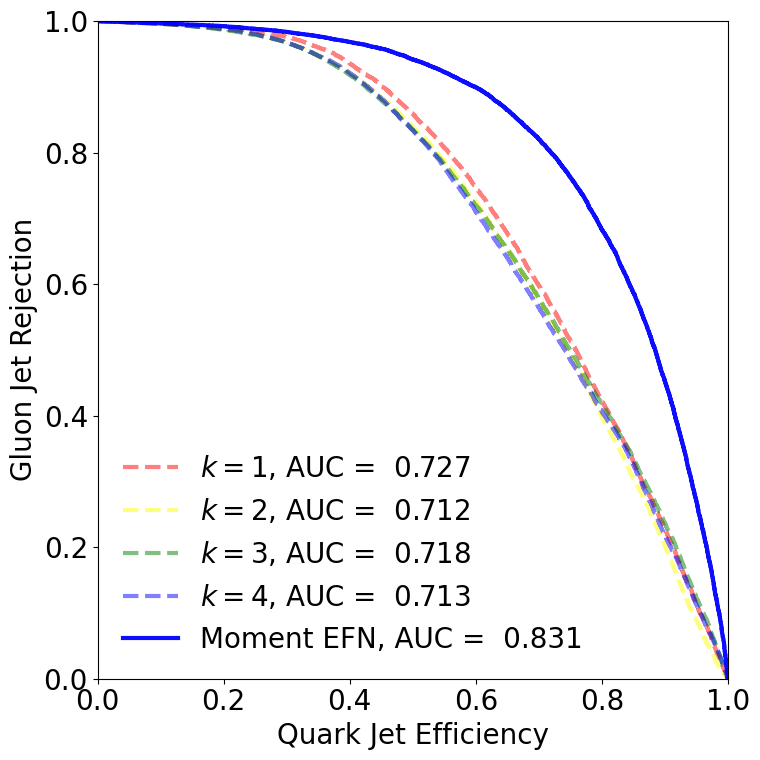

In [4]:
from energyflow.archs.moment import EFN_moment, PFN_moment

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['font.size'] = '20'

rocs = []
colors = ['red', 'yellow', 'green', 'blue', 'purple', 'pink', "grey", "black"]

for i, k_order in enumerate([1, 2, 3, 4]):


    (X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,:k_order+1], Y2, val=val, test=test)

    dense_sizes = (1,)

    dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='linear')
    dnn.load_weights(f"Data/dnn/linear_O{k_order}.keras")


    # get predictions on test data
    preds = dnn.predict(X_test, batch_size=1000)


    # get ROC curve if we have sklearn
    rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()

    if False:
        l = "EFN"
    else:
        l = f"$k = {k_order}$, AUC = {auc : .3f}"
    plt.plot(rocs[i][1], 1-rocs[i][0], '-', color = colors[i], alpha = 0.5, label = l, lw = 3, ls = "--")


# ##### Original #####

X, Y = qg_jets.load(train+val+test)
X = X[:,:,:3].astype(np.float32)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

(z_train, z_val, z_test,
p_train, p_val, p_test,
Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

X_train = [z_train, p_train]
X_val = [z_val, p_val]
X_test = [z_test, p_test]

dictionary = {'Phi_mapping_dim' : [2,1],
                                        'output_dim' : 1, 'output_act' : 'sigmoid',
                                        'Phi_sizes' : [100, 100], 'Phi_acts' : 'LeakyReLU', "Phi_l1_regs" : 1e-6,
                                        'F_sizes' : [100,100,100], 'F_acts': 'LeakyReLU', "F_l1_regs" :  1e-6,
                                        'order' : 4 , 'architecture_type':'moment',
                                        'loss': 'binary_crossentropy',}
# moment_efn = EFN_moment(**dictionary, summary=False)



# for layer in moment_efn.layers:
#     if  len(layer.get_weights()) > 0 :
#         print(layer.name, np.mean(layer.get_weights()[0]))


# # moment_efn.load_weights("Data/qg_EFN_latent/order_4/Models/O4_L1_2Phi100_3F100_0.keras", by_name=True)
# for layer in moment_efn.layers:
#     if  len(layer.get_weights()) > 0 :
#         print(layer.name, np.mean(layer.get_weights()[0]))

# # # initialize
# # moment_efn.fit(X_train, Y_train, epochs = 50)
# # moment_efn.save_weights("Data/qg_EFN_latent/order_4/Models/O4_L1_2Phi100_3F100_0.keras")

# preds = moment_efn.predict(X_test, batch_size=1000)

# print(preds.shape, Y_test.shape)

# get ROC curve if we have sklearn
rocs.append(np.load("roc.npy"))
# np.save("roc", roc_curve(Y_test, preds))

# get area under the ROC curve
auc = 0.831 #roc_auc_score(Y_test, preds)
print()
print('AUC:', auc)
print()


plt.plot(rocs[-1][1], (1-rocs[-1][0]) , '-', color = "blue", alpha = 0.95, label = f"Moment EFN, AUC = {auc: .3f}", lw = 3)





# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)


plt.savefig("Plots/analytic_auc.pdf")
plt.show()




In [5]:



# Parameters 
val = 5000
test = 5000
k_order = 4

epochs = 50
batch_size=512
callbacks =None
verbose = 2

# directory = f"/n/home01/rikab/moment/models/O{k_order}/"
###########

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [k_order,] #
input_dim = 2
output_dim = 1


max_L = 2**(8-k_order)
F_width = 100
Phi_width = 100


Ls = []
j = max_L
while j >= 1:
    Ls.append(j)
    j = j / 2

num_samples = len(Ls)


# max_L_per_order = [2**(8-k_order),]
# F_min, F_max = 100
# Phi_min, Phi_max = 100
# logN_max = 6.5

def log_features(x):


    a = 1
    b = 0.5
    c = 0.01

    zs = x[:,0]
    
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    ls = np.power(rs, 0.25)
    
    l0 = 1.0
    l1 = np.sum(zs * ls**1)
    l2 = np.sum(zs * ls**2)
    l3 = np.sum(zs * ls**3)
    l4 = np.sum(zs * ls**4)

    return (l0, l1, l2, l3, l4)



X, Y = qg_jets.load(train+val+test)
Y = to_categorical(Y, num_classes=2)
print("Data loaded!")


features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append(log_features(x))

features = np.array(features)
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(np.array(features), Y, val=val, test=test)




Data loaded!


In [6]:

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=4+1, dense_sizes=dense_sizes)

# train model
dnn.fit(X_train, Y_train,
        epochs=50,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)

angularity_rocs = []
# get ROC curve if we have sklearn
if roc_curve:
    angularity_rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()



Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               600       
                                                                 
 activation_16 (Activation)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_17 (Activation)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_18 (Activation)  (None, 100)               0   

2023-08-31 18:49:51.070973: W tensorflow/c/c_api.cc:300] Operation '{name:'training_8/Adam/dense_0_8/bias/v/Assign' id:2765 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/dense_0_8/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/dense_0_8/bias/v, training_8/Adam/dense_0_8/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 5us/sample - loss: 0.5790 - acc: 0.6889 - val_loss: 0.5732 - val_acc: 0.7012
Epoch 2/50
 24000/650000 [>.............................] - ETA: 3s - loss: 0.5654 - acc: 0.7028

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-31 18:49:54.218301: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_8/mul' id:2624 op device:{requested: '', assigned: ''} def:{{{node loss_8/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_8/mul/x, loss_8/activation_19_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 5us/sample - loss: 0.5643 - acc: 0.7030 - val_loss: 0.5787 - val_acc: 0.6938
Epoch 3/50
650000/650000 [==============================] - 3s 5us/sample - loss: 0.5611 - acc: 0.7056 - val_loss: 0.5683 - val_acc: 0.7048
Epoch 4/50
650000/650000 [==============================] - 3s 5us/sample - loss: 0.5609 - acc: 0.7060 - val_loss: 0.5676 - val_acc: 0.7056
Epoch 5/50
650000/650000 [==============================] - 3s 5us/sample - loss: 0.5606 - acc: 0.7060 - val_loss: 0.5695 - val_acc: 0.7048
Epoch 6/50
134000/650000 [=====>........................] - ETA: 2s - loss: 0.5608 - acc: 0.7057

KeyboardInterrupt: 

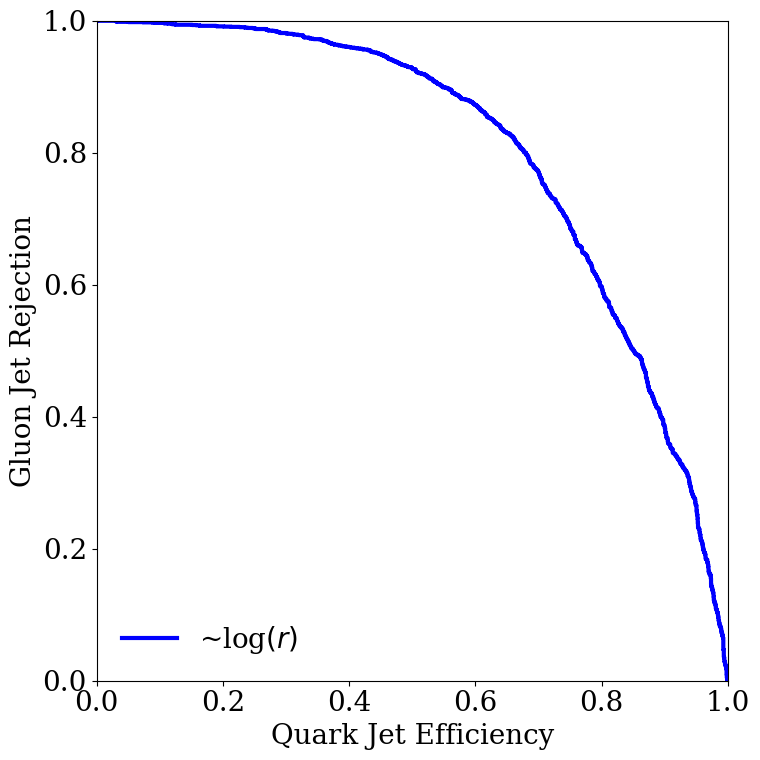

In [ ]:
# some nicer plot settings 
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.autolayout'] = True

# iterate over the ROC curves and plot them
labels = ["~log$(r)$", "Angularities"]
colors = ["blue", "black"]
for i in range(len(angularity_rocs)):
    plt.plot(angularity_rocs[i][1], 1-angularity_rocs[i][0], '-', label = labels[i], lw = 3, color = colors[i])

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()